In [217]:
import pandas as pd
import numpy as np
import os
import math

import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
from torch.nn import LSTM, GRU
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.nn.utils.rnn import pad_packed_sequence

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
from geopy.distance import geodesic

import pyreadr
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy, MeanFieldVariationalDistribution
from gpytorch.models import ApproximateGP
from gpytorch.mlls import VariationalELBO

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

## Read the lima dataset

In [218]:
lima_train_df = pd.read_csv("/Users/guptsh/Downloads/PM25/transfer-learning-propagation/data/LIMA_data/Lima_train.csv")

In [219]:
print("Shape", lima_train_df.shape)
print("Columns", lima_train_df.columns)

Shape (8470, 22)
Columns Index(['ID', 'Lat', 'Lon', 'pm25_value', 'AOD550', 'temp_2m', 'rhum',
       'zonal_wind_10m', 'merid_wind_10m', 'surf_pres', 'hpbl', 'conv_prec',
       'short_radi_surf', 'NDVI', 'DEM', 'Population', 'distance',
       'NLCD_Developed', 'year', 'month', 'doy', 'rid'],
      dtype='object')


## Unique lima years
### We focus on year = 2016

In [220]:
unique_years = lima_train_df['year'].unique()

lima_11_df = lima_train_df[lima_train_df['year'] == 2011]
lima_12_df = lima_train_df[lima_train_df['year'] == 2012]
lima_13_df = lima_train_df[lima_train_df['year'] == 2013]
lima_14_df = lima_train_df[lima_train_df['year'] == 2014]
lima_15_df = lima_train_df[lima_train_df['year'] == 2015]
lima_16_df = lima_train_df[lima_train_df['year'] == 2016]

unique_sensors = lima_train_df.groupby('year')['ID'].nunique()

print("Unique years:", unique_years) 
print("Shape of each year data:", lima_11_df.shape, lima_12_df.shape, lima_13_df.shape, 
      lima_14_df.shape, lima_15_df.shape, lima_16_df.shape)
print("Columns of the data:", lima_train_df.columns)
print("Unique sensors per year:\n", unique_sensors)

Unique years: [2011 2012 2013 2014 2015 2016]
Shape of each year data: (93, 22) (1582, 22) (406, 22) (1440, 22) (2530, 22) (2419, 22)
Columns of the data: Index(['ID', 'Lat', 'Lon', 'pm25_value', 'AOD550', 'temp_2m', 'rhum',
       'zonal_wind_10m', 'merid_wind_10m', 'surf_pres', 'hpbl', 'conv_prec',
       'short_radi_surf', 'NDVI', 'DEM', 'Population', 'distance',
       'NLCD_Developed', 'year', 'month', 'doy', 'rid'],
      dtype='object')
Unique sensors per year:
 year
2011     2
2012     6
2013     6
2014    10
2015    10
2016    10
Name: ID, dtype: int64


## Lima sensors on the map

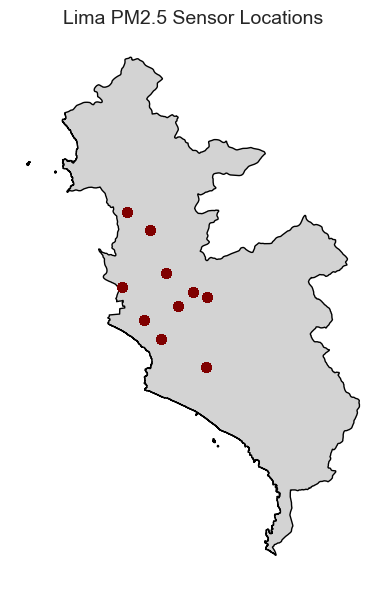

In [221]:
sns.set_style('white')

peru_map_df = gpd.read_file('/Users/guptsh/Downloads/PM25/transfer-learning-propagation/data/Shape-files/Peru_shape2/PER_adm2.shp')
lima_map_df = peru_map_df[peru_map_df['NAME_2'] == 'Lima']

geometry_lima = [Point(xy) for xy in zip(lima_16_df['Lon'], lima_16_df['Lat'])]
gdf_lima = GeoDataFrame(lima_16_df, crs='EPSG:4326', geometry=geometry_lima)

fig, ax = plt.subplots(figsize=(10, 6))
lima_map_df.plot(ax=ax, color='lightgrey', edgecolor='black')  
gdf_lima.plot(ax=ax, marker='o', color='maroon', markersize = 40)   

ax.set_axis_off()
plt.title("Lima PM2.5 Sensor Locations", fontsize=14)
plt.tight_layout()
plt.show()

## Feature selection of standard Lima columns

In [222]:
rename_map_lima_to_std = {
    'doy': 'day',
    'month': 'month',
    'Lon': 'lon',
    'Lat': 'lat',
    'rid': 'rid',
    'temp_2m': 'nldas_tmp2m',
    'rhum': 'nldas_rh2m',
    'surf_pres': 'nldas_pressfc',
    'conv_prec': 'nldas_pcpsfc',
    'short_radi_surf': 'nldas_dswrfsfc',
    'DEM': 'elev',
    'Population': 'pd',
    'zonal_wind_10m': 'nldas_ugrd10m',
    'merid_wind_10m': 'nldas_vgrd10m',
    'AOD550': 'aod',
    'pm25_value': 'pm25_value'
}

# Rename Lima dataset columns to standard names
lima_16_df = lima_16_df.rename(columns=rename_map_lima_to_std)

# Keep only the standardized columns in Lima
lima_16_df = lima_16_df[list(rename_map_lima_to_std.values())]

print("New columns are:", lima_16_df.columns)

New columns are: Index(['day', 'month', 'lon', 'lat', 'rid', 'nldas_tmp2m', 'nldas_rh2m',
       'nldas_pressfc', 'nldas_pcpsfc', 'nldas_dswrfsfc', 'elev', 'pd',
       'nldas_ugrd10m', 'nldas_vgrd10m', 'aod', 'pm25_value'],
      dtype='object')


## Splitting Lima dataset into train and test

In [223]:
lima_splits = []

for seed in range(20):
    unique_sensors = lima_16_df[['lon', 'lat']].drop_duplicates().reset_index(drop=True)

    train_sensors, test_sensors = train_test_split(
        unique_sensors, test_size=0.6, random_state=seed
    )

    train_mask = lima_16_df.apply(
        lambda row: ((row['lon'], row['lat']) in train_sensors.values), axis=1
    )
    test_mask = ~train_mask

    train_df = lima_16_df[train_mask].reset_index(drop=True)
    test_df = lima_16_df[test_mask].reset_index(drop=True)
    lima_splits.append((train_df, test_df))

## Visualizing splits

#### For single fold

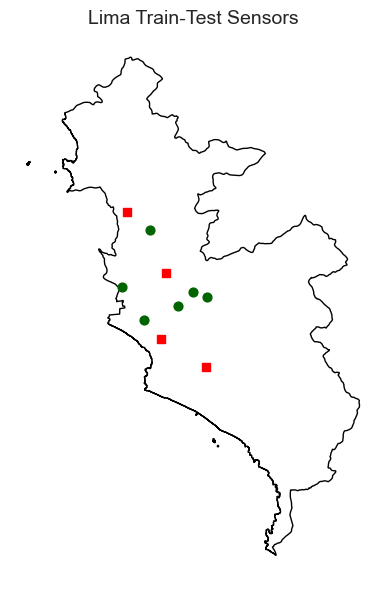

In [214]:
sns.set_style('white')

peru_map_df = gpd.read_file('/Users/guptsh/Downloads/PM25/transfer-learning-propagation/data/Shape-files/Peru_shape2/PER_adm2.shp')
lima_map_df = peru_map_df[peru_map_df['NAME_2'] == 'Lima']

crs = 'EPSG:4326'

fold_num = 1
train_df, test_df = lima_splits[fold_num]

# Unique train sensor locations
train_locations = train_df[['lon', 'lat']].drop_duplicates()
train_gdf = GeoDataFrame(
    train_locations,
    crs=crs,
    geometry=[Point(xy) for xy in zip(train_locations.lon, train_locations.lat)]
)

# Unique test sensor locations
test_locations = test_df[['lon', 'lat']].drop_duplicates()
test_gdf = GeoDataFrame(
    test_locations,
    crs=crs,
    geometry=[Point(xy) for xy in zip(test_locations.lon, test_locations.lat)]
)

fig, ax = plt.subplots(figsize=(10, 6))
lima_map_df.plot(ax=ax, color='white', edgecolor='black')                   

train_gdf.plot(ax=ax, color='red', marker='s', markersize=40, label='Train Sensors')
test_gdf.plot(ax=ax, color='darkgreen', marker='o', markersize=40, label='Test Sensors')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.title(f"Lima Train-Test Sensors", fontsize=14)
# plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig("lima_sensors_map_2.png", dpi=300, bbox_inches='tight')
plt.show()

## Visualizing initial inducing points

In [215]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df, test_df = lima_splits[1]  

target_col = 'pm25_value'
no_scale_cols = ['lat', 'lon', 'day', 'month', 'rid']
scale_cols = [col for col in train_df.columns if col not in no_scale_cols + [target_col]]

scaler = StandardScaler()
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()
train_df_scaled[scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df_scaled[scale_cols] = scaler.transform(test_df[scale_cols])

X_train = torch.tensor(train_df_scaled.drop(columns=[target_col]).values, dtype=torch.float32).to(device)
y_train = torch.tensor(train_df[target_col].values, dtype=torch.float32).to(device)
X_test = torch.tensor(test_df_scaled.drop(columns=[target_col]).values, dtype=torch.float32).to(device)
y_test = torch.tensor(test_df[target_col].values, dtype=torch.float32).to(device)

num_inducing = 200
kmeans = KMeans(n_clusters=num_inducing, n_init='auto').fit(X_train.cpu().numpy())
inducing_points = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

lat_idx = train_df_scaled.columns.get_loc("lat")
lon_idx = train_df_scaled.columns.get_loc("lon")

initial_inducing = inducing_points.detach().cpu().numpy()
initial_lat = initial_inducing[:, lat_idx]
initial_lon = initial_inducing[:, lon_idx]

#### For single fold

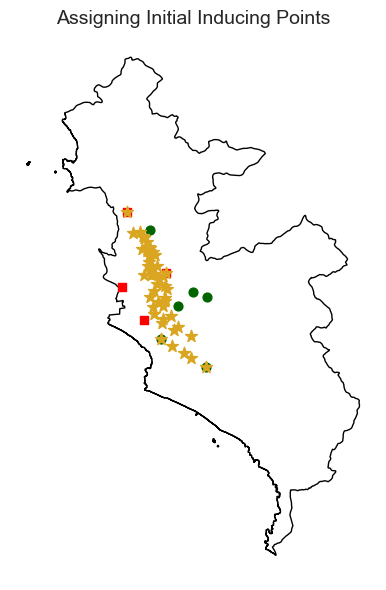

In [216]:
sns.set_style('white')

peru_map_df = gpd.read_file('/Users/guptsh/Downloads/PM25/transfer-learning-propagation/data/Shape-files/Peru_shape2/PER_adm2.shp')
lima_map_df = peru_map_df[peru_map_df['NAME_2'] == 'Lima']

crs = 'EPSG:4326'

fold_num = 0
train_df, test_df = lima_splits[fold_num]

# Unique train sensor locations
train_locations = train_df[['lon', 'lat']].drop_duplicates()
train_gdf = GeoDataFrame(
    train_locations,
    crs=crs,
    geometry=[Point(xy) for xy in zip(train_locations.lon, train_locations.lat)]
)

# Unique test sensor locations
test_locations = test_df[['lon', 'lat']].drop_duplicates()
test_gdf = GeoDataFrame(
    test_locations,
    crs=crs,
    geometry=[Point(xy) for xy in zip(test_locations.lon, test_locations.lat)]
)

# initial inducing points
unique_initial_coords = list(set(zip(initial_lon, initial_lat)))
init_inducing_gdf = GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in unique_initial_coords],
    crs=crs
)

fig, ax = plt.subplots(figsize=(10, 6))
lima_map_df.plot(ax=ax, color='white', edgecolor='black')                  

train_gdf.plot(ax=ax, color='red', marker='s', markersize=40, label='Train Sensors')
test_gdf.plot(ax=ax, color = 'darkgreen', marker='o', markersize=40, label='Test Sensors')
init_inducing_gdf.plot(ax=ax, color = 'goldenrod', marker='*', markersize=80, label='Initial Inducing Points')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.title(f"Assigning Initial Inducing Points", fontsize=14)
# plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig("lima_inducing_map_2.png", dpi=300, bbox_inches='tight')
plt.show()

## Visualizing final inducing points

#### For single fold

In [208]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df, test_df = lima_splits[1]  

target_col = 'pm25_value'
no_scale_cols = ['lat', 'lon', 'day', 'month', 'rid']
scale_cols = [col for col in train_df.columns if col not in no_scale_cols + [target_col]]

scaler = StandardScaler()
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()
train_df_scaled[scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df_scaled[scale_cols] = scaler.transform(test_df[scale_cols])

X_train = torch.tensor(train_df_scaled.drop(columns=[target_col]).values, dtype=torch.float32).to(device)
y_train = torch.tensor(train_df[target_col].values, dtype=torch.float32).to(device)
X_test = torch.tensor(test_df_scaled.drop(columns=[target_col]).values, dtype=torch.float32).to(device)
y_test = torch.tensor(test_df[target_col].values, dtype=torch.float32).to(device)

num_inducing = 200
kmeans = KMeans(n_clusters=num_inducing, n_init='auto').fit(X_train.cpu().numpy())
inducing_points = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

lat_idx = train_df_scaled.columns.get_loc("lat")
lon_idx = train_df_scaled.columns.get_loc("lon")

initial_inducing = inducing_points.detach().cpu().numpy()
initial_lat = initial_inducing[:, lat_idx]
initial_lon = initial_inducing[:, lon_idx]

class VariationalSGPRModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = MeanFieldVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            RBFKernel(ard_num_dims=inducing_points.shape[1]) +
            MaternKernel(ard_num_dims=inducing_points.shape[1])
        )
        # ScaleKernel(RBFKernel(ard_num_dims=inducing_points.shape[1]) * 
        #                                 MaternKernel(ard_num_dims=inducing_points.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# ===== Model Initialization =====
model = VariationalSGPRModel(inducing_points).to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
mll = VariationalELBO(likelihood, model, num_data=X_train.size(0))

# ===== Training Setup =====
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=1024, shuffle=True)
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.05)

# ===== Training Loop =====
model.train()
likelihood.train()
for epoch in range(1500):
    epoch_loss = 0
    
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = -mll(output, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/1500 - Loss: {epoch_loss:.3f}")
    
    torch.cuda.empty_cache()

# ===== Final Inducing Points =====
final_inducing = model.variational_strategy.inducing_points.detach().cpu().numpy()
final_lat = final_inducing[:, lat_idx]
final_lon = final_inducing[:, lon_idx]

Epoch 100/1500 - Loss: 12.278
Epoch 200/1500 - Loss: 8.943
Epoch 300/1500 - Loss: 8.405
Epoch 400/1500 - Loss: 8.018
Epoch 500/1500 - Loss: 7.670
Epoch 600/1500 - Loss: 7.338
Epoch 700/1500 - Loss: 7.017
Epoch 800/1500 - Loss: 6.739
Epoch 900/1500 - Loss: 6.504
Epoch 1000/1500 - Loss: 6.293
Epoch 1100/1500 - Loss: 6.093
Epoch 1200/1500 - Loss: 5.926
Epoch 1300/1500 - Loss: 5.772
Epoch 1400/1500 - Loss: 5.628
Epoch 1500/1500 - Loss: 5.508


/var/folders/xw/pk8h6grn7k3f0d_vdm1wntmw0000gs/T/ipykernel_33429/4201522686.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  train_gdf = train_gdf[train_gdf.geometry.within(lima_map_df.unary_union)]
/var/folders/xw/pk8h6grn7k3f0d_vdm1wntmw0000gs/T/ipykernel_33429/4201522686.py:37: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  test_gdf = test_gdf[test_gdf.geometry.within(lima_map_df.unary_union)]
/var/folders/xw/pk8h6grn7k3f0d_vdm1wntmw0000gs/T/ipykernel_33429/4201522686.py:38: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  final_inducing_gdf = final_inducing_gdf[final_inducing_gdf.geometry.within(lima_map_df.unary_union)]


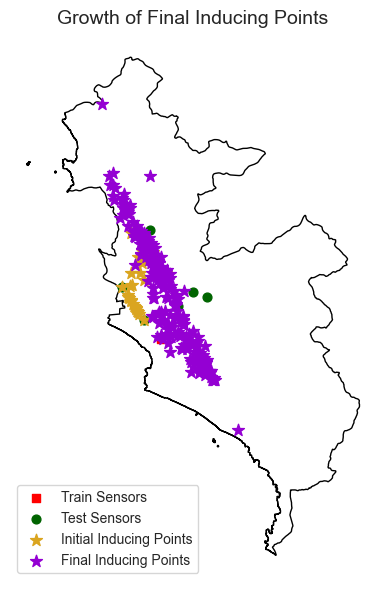

In [210]:
sns.set_style('white')

peru_map_df = gpd.read_file(
    '/Users/guptsh/Downloads/PM25/transfer-learning-propagation/data/Shape-files/Peru_shape2/PER_adm2.shp'
)
lima_map_df = peru_map_df[peru_map_df['NAME_2'] == 'Lima']

crs = 'EPSG:4326'

fold_num = 1
train_df, test_df = lima_splits[fold_num]

# === Train/Test sensor locations ===
train_locations = train_df[['lon', 'lat']].drop_duplicates()
train_gdf = GeoDataFrame(
    train_locations,
    crs=crs,
    geometry=[Point(xy) for xy in zip(train_locations.lon, train_locations.lat)]
)

test_locations = test_df[['lon', 'lat']].drop_duplicates()
test_gdf = GeoDataFrame(
    test_locations,
    crs=crs,
    geometry=[Point(xy) for xy in zip(test_locations.lon, test_locations.lat)]
)

# === Final inducing points ===
unique_final_coords = list(set(zip(final_lon, final_lat)))
final_inducing_gdf = GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in unique_final_coords],
    crs=crs
)

# === Keep only points inside Lima ===
train_gdf = train_gdf[train_gdf.geometry.within(lima_map_df.unary_union)]
test_gdf = test_gdf[test_gdf.geometry.within(lima_map_df.unary_union)]
final_inducing_gdf = final_inducing_gdf[final_inducing_gdf.geometry.within(lima_map_df.unary_union)]

fig, ax = plt.subplots(figsize=(10, 6))
lima_map_df.plot(ax=ax, color='white', edgecolor='black')

train_gdf.plot(ax=ax, color='red', marker='s', markersize=40, label='Train Sensors')
test_gdf.plot(ax=ax, color='darkgreen', marker='o', markersize=40, label='Test Sensors')
init_inducing_gdf.plot(ax=ax, color = 'goldenrod', marker='*', markersize=80, label='Initial Inducing Points')
final_inducing_gdf.plot(ax=ax, color='darkviolet', marker='*', markersize=80, label='Final Inducing Points')

ax.set_axis_off()
plt.title("Growth of Final Inducing Points", fontsize=14)
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig("legend.png", dpi=300, bbox_inches='tight')
plt.show()

### SVGPR

### single fold

In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fold_num = 0
train_df, test_df = lima_splits[fold_num]

no_scale_cols = ['pm25_value'] ##['Lat', 'Lon', 'doy', 'year']
scale_cols = [col for col in train_df.columns if col not in no_scale_cols]

scaler = StandardScaler()

train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()
train_df_scaled[scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df_scaled[scale_cols] = scaler.transform(test_df[scale_cols])

y_scaler = StandardScaler()

y_train_scaled = y_scaler.fit_transform(train_df['pm25_value'].values.reshape(-1, 1)).squeeze()
y_test_scaled = y_scaler.transform(test_df['pm25_value'].values.reshape(-1, 1)).squeeze()

X_train = torch.tensor(train_df_scaled.drop(columns=['pm25_value']).values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)

X_test = torch.tensor(test_df_scaled.drop(columns=['pm25_value']).values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

num_inducing = 200

kmeans = KMeans(n_clusters=num_inducing).fit(X_train.cpu().numpy())
inducing_points = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

class VariationalSGPRModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        
        super().__init__(variational_strategy)
        
        self.mean_module = ConstantMean()
        # self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.shape[1]))
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.shape[1]) + 
                                        MaternKernel(ard_num_dims=inducing_points.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

model = VariationalSGPRModel(inducing_points).to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
mll = VariationalELBO(likelihood, model, num_data=X_train.size(0))

batch_size = 1024
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr = 0.05)

model.train()
likelihood.train()
training_iterations = 400

for epoch in range(training_iterations):
    epoch_loss = 0
    
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = -mll(output, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{training_iterations} - Loss: {epoch_loss:.3f}")
        
    torch.cuda.empty_cache()

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = model(X_test)
    mean = preds.mean

y_pred = y_scaler.inverse_transform(mean.cpu().numpy().reshape(-1, 1)).squeeze()
y_true = test_df['pm25_value'].values

rmse_sgpr = np.sqrt(mean_squared_error(y_true, y_pred))
r2_sgpr = r2_score(y_true, y_pred)
pearson_sgpr = pearsonr(y_true, y_pred)[0]

print("\nSVGPR Results:")

print(f"  RMSE: {rmse_sgpr:.3f}")
print(f"  R²: {r2_sgpr:.3f}")
print(f"  Pearson r: {pearson_sgpr:.3f}")
print(f"  Pearson r²: {pearson_sgpr**2:.3f}")

Epoch 1/400 - Loss: 1.957
Epoch 10/400 - Loss: 1.467
Epoch 20/400 - Loss: 1.256
Epoch 30/400 - Loss: 1.137
Epoch 40/400 - Loss: 1.008
Epoch 50/400 - Loss: 0.881
Epoch 60/400 - Loss: 0.781
Epoch 70/400 - Loss: 0.726
Epoch 80/400 - Loss: 0.709
Epoch 90/400 - Loss: 0.700
Epoch 100/400 - Loss: 0.694
Epoch 110/400 - Loss: 0.688
Epoch 120/400 - Loss: 0.684
Epoch 130/400 - Loss: 0.681
Epoch 140/400 - Loss: 0.677
Epoch 150/400 - Loss: 0.676
Epoch 160/400 - Loss: 0.672
Epoch 170/400 - Loss: 0.670
Epoch 180/400 - Loss: 0.669
Epoch 190/400 - Loss: 0.667
Epoch 200/400 - Loss: 0.665
Epoch 210/400 - Loss: 0.665
Epoch 220/400 - Loss: 0.663
Epoch 230/400 - Loss: 0.661
Epoch 240/400 - Loss: 0.661
Epoch 250/400 - Loss: 0.660
Epoch 260/400 - Loss: 0.659
Epoch 270/400 - Loss: 0.658
Epoch 280/400 - Loss: 0.657
Epoch 290/400 - Loss: 0.657
Epoch 300/400 - Loss: 0.659
Epoch 310/400 - Loss: 0.656
Epoch 320/400 - Loss: 0.655
Epoch 330/400 - Loss: 0.654
Epoch 340/400 - Loss: 0.655
Epoch 350/400 - Loss: 0.654
Epo

### All folds

In [225]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_rmse, all_r2, all_pearson = [], [], []

for fold_num, (train_df, test_df) in enumerate(lima_splits):
    print(f"\n========== Fold {fold_num+1} ==========")

    no_scale_cols = ['pm25_value']
    scale_cols = [col for col in train_df.columns if col not in no_scale_cols]

    scaler = StandardScaler()
    train_df_scaled = train_df.copy()
    test_df_scaled = test_df.copy()
    train_df_scaled[scale_cols] = scaler.fit_transform(train_df[scale_cols])
    test_df_scaled[scale_cols] = scaler.transform(test_df[scale_cols])

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(train_df['pm25_value'].values.reshape(-1, 1)).squeeze()
    y_test_scaled = y_scaler.transform(test_df['pm25_value'].values.reshape(-1, 1)).squeeze()

    X_train = torch.tensor(train_df_scaled.drop(columns=['pm25_value']).values, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)

    X_test = torch.tensor(test_df_scaled.drop(columns=['pm25_value']).values, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

    num_inducing = 200
    kmeans = KMeans(n_clusters=num_inducing).fit(X_train.cpu().numpy())
    inducing_points = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

    class VariationalSGPRModel(ApproximateGP):
        def __init__(self, inducing_points):
            variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
            variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
            super().__init__(variational_strategy)
            self.mean_module = ConstantMean()
            # self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.shape[1]))
            self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.shape[1]) + 
                                        MaternKernel(ard_num_dims=inducing_points.shape[1]))

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return MultivariateNormal(mean_x, covar_x)

    model = VariationalSGPRModel(inducing_points).to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    mll = VariationalELBO(likelihood, model, num_data=X_train.size(0))

    batch_size = 1024
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=0.05)

    model.train()
    likelihood.train()
    training_iterations = 1500

    for epoch in range(training_iterations):
        epoch_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            output = model(xb)
            loss = -mll(output, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1}/{training_iterations} - Loss: {epoch_loss:.3f}")
        torch.cuda.empty_cache()

    # -------------------------
    # Evaluation
    # -------------------------
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = model(X_test)
        mean = preds.mean

    y_pred = y_scaler.inverse_transform(mean.cpu().numpy().reshape(-1, 1)).squeeze()
    y_true = test_df['pm25_value'].values

    rmse_sgpr = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_sgpr = r2_score(y_true, y_pred)
    pearson_sgpr = pearsonr(y_true, y_pred)[0]

    print(f"  Fold {fold_num+1} RMSE: {rmse_sgpr:.3f}")
    print(f"  Fold {fold_num+1} R²: {r2_sgpr:.3f}")
    print(f"  Fold {fold_num+1} Pearson r: {pearson_sgpr:.3f}")

    all_rmse.append(rmse_sgpr)
    all_r2.append(r2_sgpr)
    all_pearson.append(pearson_sgpr)

print("\n========== Cross-Fold Average ==========")
print(f"Average RMSE: {np.mean(all_rmse):.3f}")
print(f"Average R²: {np.mean(all_r2):.3f}")
print(f"Average Pearson r: {np.mean(all_pearson):.3f}")
print(f"Average Pearson r²: {np.mean(np.square(all_pearson)):.3f}")


========== Fold 1 ==========
  Epoch 1/1500 - Loss: 2.457
  Epoch 50/1500 - Loss: 1.042
  Epoch 100/1500 - Loss: 0.702
  Epoch 150/1500 - Loss: 0.661
  Epoch 200/1500 - Loss: 0.650
  Epoch 250/1500 - Loss: 0.641
  Epoch 300/1500 - Loss: 0.636
  Epoch 350/1500 - Loss: 0.634
  Epoch 400/1500 - Loss: 0.630
  Epoch 450/1500 - Loss: 0.628
  Epoch 500/1500 - Loss: 0.626
  Epoch 550/1500 - Loss: 0.626
  Epoch 600/1500 - Loss: 0.624
  Epoch 650/1500 - Loss: 0.623
  Epoch 700/1500 - Loss: 0.623
  Epoch 750/1500 - Loss: 0.622
  Epoch 800/1500 - Loss: 0.620
  Epoch 850/1500 - Loss: 0.621
  Epoch 900/1500 - Loss: 0.620
  Epoch 950/1500 - Loss: 0.619
  Epoch 1000/1500 - Loss: 0.619
  Epoch 1050/1500 - Loss: 0.618
  Epoch 1100/1500 - Loss: 0.618
  Epoch 1150/1500 - Loss: 0.618
  Epoch 1200/1500 - Loss: 0.617
  Epoch 1250/1500 - Loss: 0.619
  Epoch 1300/1500 - Loss: 0.617
  Epoch 1350/1500 - Loss: 0.616
  Epoch 1400/1500 - Loss: 0.616
  Epoch 1450/1500 - Loss: 0.616
  Epoch 1500/1500 - Loss: 0.616
 

### GPR

In [131]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel

all_rmse, all_r2, all_pearson_r, all_pearson_r2 = [], [], [], []

for fold_num, (train_df_gp, test_df_gp) in enumerate(lima_splits):
    print(f"\n=== Fold {fold_num + 1} ===")

    feature_columns = [col for col in train_df_gp.columns if col != 'pm25_value']

    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df_gp[feature_columns].values)
    X_test = scaler.transform(test_df_gp[feature_columns].values)

    y_train = train_df_gp['pm25_value'].values
    y_test = test_df_gp['pm25_value'].values

    print(f"Training data X shape: {X_train.shape}, y shape: {y_train.shape}")
    print(f"Testing data X shape: {X_test.shape}, y shape: {y_test.shape}")

    # Kernel
    kernel = ConstantKernel(1.0) * RBF(length_scale=0.5) + WhiteKernel(noise_level=0.1)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

    gp.fit(X_train, y_train)
    print("Training complete.")
    print(f"Optimized Kernel: {gp.kernel_}")

    y_pred, sigma = gp.predict(X_test, return_std=True)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    pearson_r = pearsonr(y_test, y_pred)[0]
    pearson_r2 = pearson_r ** 2

    print(f"Fold {fold_num + 1} RMSE: {rmse:.4f}")
    print(f"Fold {fold_num + 1} R²: {r2:.4f}")
    print(f"Fold {fold_num + 1} Pearson r: {pearson_r:.4f}")
    print(f"Fold {fold_num + 1} Pearson r²: {pearson_r2:.4f}")

    all_rmse.append(rmse)
    all_r2.append(r2)
    all_pearson_r.append(pearson_r)
    all_pearson_r2.append(pearson_r2)

print("\n=== Cross-Fold Results ===")
print(f"Average RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average R²: {np.mean(all_r2):.4f} ± {np.std(all_r2):.4f}")
print(f"Average Pearson r: {np.mean(all_pearson_r):.4f} ± {np.std(all_pearson_r):.4f}")
print(f"Average Pearson r²: {np.mean(all_pearson_r2):.4f} ± {np.std(all_pearson_r2):.4f}")


=== Fold 1 ===
Training data X shape: (1020, 15), y shape: (1020,)
Testing data X shape: (1399, 15), y shape: (1399,)
Training complete.
Optimized Kernel: 24.9**2 * RBF(length_scale=6.49) + WhiteKernel(noise_level=28.2)
Fold 1 RMSE: 10.2991
Fold 1 R²: 0.3798
Fold 1 Pearson r: 0.6315
Fold 1 Pearson r²: 0.3988

=== Fold 2 ===
Training data X shape: (993, 15), y shape: (993,)
Testing data X shape: (1426, 15), y shape: (1426,)
Training complete.
Optimized Kernel: 25.3**2 * RBF(length_scale=6.18) + WhiteKernel(noise_level=39.1)
Fold 2 RMSE: 10.2328
Fold 2 R²: 0.4764
Fold 2 Pearson r: 0.7072
Fold 2 Pearson r²: 0.5001

=== Fold 3 ===
Training data X shape: (979, 15), y shape: (979,)
Testing data X shape: (1440, 15), y shape: (1440,)
Training complete.
Optimized Kernel: 20.7**2 * RBF(length_scale=5.19) + WhiteKernel(noise_level=42.1)
Fold 3 RMSE: 9.9981
Fold 3 R²: 0.3688
Fold 3 Pearson r: 0.7143
Fold 3 Pearson r²: 0.5102

=== Fold 4 ===
Training data X shape: (1025, 15), y shape: (1025,)
Test

### GBR

In [125]:
from sklearn.ensemble import GradientBoostingRegressor

all_rmse, all_r2, all_pearson_r, all_pearson_r2 = [], [], [], []

for fold_num, (train_df_gp, test_df_gp) in enumerate(lima_splits):
    print(f"\n=== Fold {fold_num + 1} ===")

    feature_columns = [col for col in train_df_gp.columns if col != 'pm25_value']

    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df_gp[feature_columns].values)
    X_test = scaler.transform(test_df_gp[feature_columns].values)

    y_train = train_df_gp['pm25_value'].values
    y_test = test_df_gp['pm25_value'].values

    print(f"Training data X shape: {X_train.shape}, y shape: {y_train.shape}")
    print(f"Testing data X shape: {X_test.shape}, y shape: {y_test.shape}")

    gbr = GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=None,
        random_state=42
    )

    gbr.fit(X_train, y_train)
    print("Training complete.")

    y_pred = gbr.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    pearson_r, _ = pearsonr(y_test, y_pred)
    pearson_r2 = pearson_r ** 2

    print(f"Fold {fold_num + 1} RMSE: {rmse:.4f}")
    print(f"Fold {fold_num + 1} R²: {r2:.4f}")
    print(f"Fold {fold_num + 1} Pearson r: {pearson_r:.4f}")
    print(f"Fold {fold_num + 1} Pearson r²: {pearson_r2:.4f}")

    all_rmse.append(rmse)
    all_r2.append(r2)
    all_pearson_r.append(pearson_r)
    all_pearson_r2.append(pearson_r2)

print("\n=== Gradient Boosting - Cross-Fold Results ===")
print(f"Average RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average R²: {np.mean(all_r2):.4f} ± {np.std(all_r2):.4f}")
print(f"Average Pearson r: {np.mean(all_pearson_r):.4f} ± {np.std(all_pearson_r):.4f}")
print(f"Average Pearson r²: {np.mean(all_pearson_r2):.4f} ± {np.std(all_pearson_r2):.4f}")


=== Fold 1 ===
Training data X shape: (1020, 15), y shape: (1020,)
Testing data X shape: (1399, 15), y shape: (1399,)
Training complete.
Fold 1 RMSE: 10.4603
Fold 1 R²: 0.3603
Fold 1 Pearson r: 0.6271
Fold 1 Pearson r²: 0.3933

=== Fold 2 ===
Training data X shape: (993, 15), y shape: (993,)
Testing data X shape: (1426, 15), y shape: (1426,)
Training complete.
Fold 2 RMSE: 10.7221
Fold 2 R²: 0.4251
Fold 2 Pearson r: 0.7013
Fold 2 Pearson r²: 0.4918

=== Fold 3 ===
Training data X shape: (979, 15), y shape: (979,)
Testing data X shape: (1440, 15), y shape: (1440,)
Training complete.
Fold 3 RMSE: 11.9019
Fold 3 R²: 0.1056
Fold 3 Pearson r: 0.6016
Fold 3 Pearson r²: 0.3620

=== Fold 4 ===
Training data X shape: (1025, 15), y shape: (1025,)
Testing data X shape: (1394, 15), y shape: (1394,)
Training complete.
Fold 4 RMSE: 10.5001
Fold 4 R²: 0.3131
Fold 4 Pearson r: 0.5764
Fold 4 Pearson r²: 0.3323

=== Fold 5 ===
Training data X shape: (991, 15), y shape: (991,)
Testing data X shape: (142

In [229]:
all_rmse, all_r2, all_pearson_r, all_pearson_r2 = [], [], [], []

for fold_num, (train_df_gp, test_df_gp) in enumerate(lima_splits):
    print(f"\n=== Fold {fold_num + 1} ===")

    feature_columns = [col for col in train_df_gp.columns if col != 'pm25_value']

    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df_gp[feature_columns].values)
    X_test = scaler.transform(test_df_gp[feature_columns].values)

    y_train = train_df_gp['pm25_value'].values
    y_test = test_df_gp['pm25_value'].values

    print(f"Training data X shape: {X_train.shape}, y shape: {y_train.shape}")
    print(f"Testing data X shape: {X_test.shape}, y shape: {y_test.shape}")

    lasso = Lasso(alpha=1.0, random_state=42)

    lasso.fit(X_train, y_train)
    print("Training complete.")

    y_pred = lasso.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    pearson_r, _ = pearsonr(y_test, y_pred)
    pearson_r2 = pearson_r ** 2

    print(f"Fold {fold_num + 1} RMSE: {rmse:.4f}")
    print(f"Fold {fold_num + 1} R²: {r2:.4f}")
    print(f"Fold {fold_num + 1} Pearson r: {pearson_r:.4f}")
    print(f"Fold {fold_num + 1} Pearson r²: {pearson_r2:.4f}")

    all_rmse.append(rmse)
    all_r2.append(r2)
    all_pearson_r.append(pearson_r)
    all_pearson_r2.append(pearson_r2)

print("\n=== Lasso Regression - Cross-Fold Results ===")
print(f"Average RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average R²: {np.mean(all_r2):.4f} ± {np.std(all_r2):.4f}")
print(f"Average Pearson r: {np.mean(all_pearson_r):.4f} ± {np.std(all_pearson_r):.4f}")
print(f"Average Pearson r²: {np.mean(all_pearson_r2):.4f} ± {np.std(all_pearson_r2):.4f}")


=== Fold 1 ===
Training data X shape: (1020, 15), y shape: (1020,)
Testing data X shape: (1399, 15), y shape: (1399,)
Training complete.
Fold 1 RMSE: 10.8805
Fold 1 R²: 0.3078
Fold 1 Pearson r: 0.5652
Fold 1 Pearson r²: 0.3195

=== Fold 2 ===
Training data X shape: (993, 15), y shape: (993,)
Testing data X shape: (1426, 15), y shape: (1426,)
Training complete.
Fold 2 RMSE: 10.8857
Fold 2 R²: 0.4074
Fold 2 Pearson r: 0.6573
Fold 2 Pearson r²: 0.4320

=== Fold 3 ===
Training data X shape: (979, 15), y shape: (979,)
Testing data X shape: (1440, 15), y shape: (1440,)
Training complete.
Fold 3 RMSE: 10.8440
Fold 3 R²: 0.2575
Fold 3 Pearson r: 0.5186
Fold 3 Pearson r²: 0.2690

=== Fold 4 ===
Training data X shape: (1025, 15), y shape: (1025,)
Testing data X shape: (1394, 15), y shape: (1394,)
Training complete.
Fold 4 RMSE: 12.1037
Fold 4 R²: 0.0873
Fold 4 Pearson r: 0.3807
Fold 4 Pearson r²: 0.1449

=== Fold 5 ===
Training data X shape: (991, 15), y shape: (991,)
Testing data X shape: (142